<h1>Лабораторная работа 1</h1>
Енгоян Сергей А-01м-25<br>
Визуальный анализ временного ряда и обработка аномальных измерений.<br> 
Непараметрические и параметрические методы обнаружения и выделения <br>
компонент временного ряда, анализ случайности и стационарности временных рядов.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

<h3>1) Моделирование временного ряда</h3>

In [25]:
def time_series(t, N, num=1):
    e = np.random.normal(loc=0, scale=1, size=N)
    a0 = np.random.uniform(0.1, 0.5)
    a1 = np.random.uniform(0.01, 0.1)
    a2 = np.random.uniform(0.5, 1.0)

    result = []
    if num == 1:
        for i in range(N):
            result.append(a0 * np.cos(a1 * 2 * np.pi * t[i]) + a2 * e[i])
        return result
    elif num == 2:
        for i in range(N):
            result.append(abs(e[i]) ** (0.1 * t[i]) + 2 * abs(e[i]))
        return result

<h3>2) Анализ аномалий с помощью эллипса рассеяния</h3>

In [26]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

In [27]:
def diffs(X):
    X = np.array(X, dtype=float)
    N = len(X)

    diff_x = np.full(N, np.nan)  # разница с предыдущим
    diff_y = np.full(N, np.nan)  # разница с следующим

    # начиная со второго элемента до последнего, считаем разницу с предыдущим
    diff_x[1:-1] = X[1:-1] - X[0:-2]

    # начиная со второго до предпоследнего, считаем разницу с следующим
    diff_y[1:-1] = X[2:] - X[1:-1]

    return diff_x, diff_y 

In [28]:
def ellips(y1, PARAM):
    # === 1. Приращения ===
    dx, dy = diffs(y1)

    # === 2. Очистка от NaN ===
    mask = ~np.isnan(dx) & ~np.isnan(dy)
    dx_clean = dx[mask]
    dy_clean = dy[mask]

    # === 3. Центр выборки ===
    mean_x = np.mean(dx_clean)
    mean_y = np.mean(dy_clean)

    # === 4. Ковариационная матрица ===
    cov = np.cov(dx_clean, dy_clean)

    # === 5. Главные оси ===
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # === 6. Размеры эллипса ===
    confidence_val = chi2.ppf(PARAM, df=2)
    width, heigth = 2 * np.sqrt(confidence_val * vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    el = Ellipse(
        xy=(mean_x, mean_y),
        width=width,
        height=heigth,
        angle=angle,
        edgecolor='r',
        facecolor='none',
        lw=2
    )

    # === 7. Махаланобисово расстояние ===
    inv_cov = np.linalg.inv(cov)
    diffs_array = np.vstack([dx_clean - mean_x, dy_clean - mean_y]).T
    mahal_sq = np.sum(diffs_array @ inv_cov * diffs_array, axis=1)

    # === 8. Отбор аномалий (2-й и 4-й квадрант относительно (0,0)) ===
    in_quadrant = ((dx_clean < 0) & (dy_clean > 0)) | ((dx_clean > 0) & (dy_clean < 0))
    outliers_mask = (mahal_sq > confidence_val) & in_quadrant

    # === 9. Координаты и индексы аномалий ===
    outlier_x = dx_clean[outliers_mask]
    outlier_y = dy_clean[outliers_mask]
    outlier_indices = np.where(mask)[0][outliers_mask]

    # === 10. Печать аномалий ===
    anomalies = []
    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        
        print(f"{idx} : {y1[idx]} {x} {y}")

    # === 11. Визуализация ===
    fig, ax = plt.subplots()
    ax.spines['left'].set_position(('data', mean_x))
    ax.spines['bottom'].set_position(('data', mean_y))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.scatter(dx_clean, dy_clean, s=10, label='Точки')
    ax.scatter(outlier_x, outlier_y, color='orange', s=30, label='Аномалии')

    # Подписи индексов у оранжевых точек
    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        ax.annotate(str(idx), (x, y), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)

    ax.add_patch(el)
    ax.legend()
    plt.show()

    return 

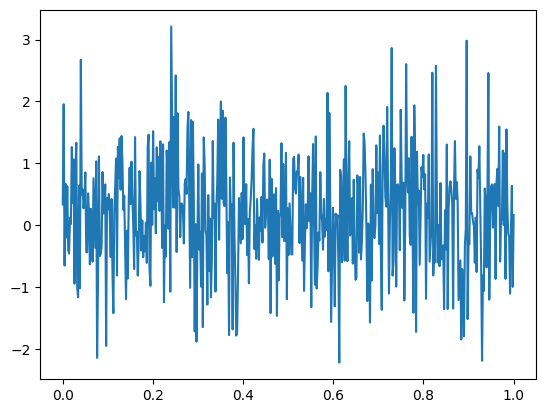

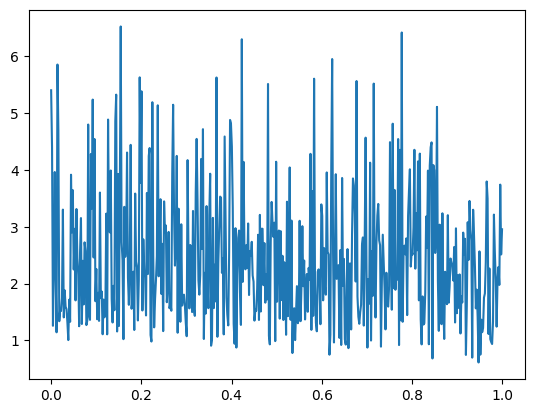

In [29]:
N = 500        # Количество точек
T = 1           # Время моделирования

t = np.linspace(0, T, N)

y1 = time_series(t, N, num=1)
y2 = time_series(t, N, num=2)

plt.plot(t, y1)
plt.show()
plt.plot(t, y2)
plt.show()

19 : -1.0165518758798509 -1.655421578594217 3.6900694099822138
20 : 2.673517534102363 3.6900694099822138 -2.186989172813615
119 : -1.0726408077101304 -2.416704696532296 4.28366394847668
120 : 3.2110231407665495 4.28366394847668 -1.422839232658849
156 : 1.4199995227719755 3.065910632522689 -0.4260030158399992
307 : 0.8946196655608961 3.1109702832902633 -0.10986213332878125
364 : 2.8625226458668314 2.259889564805744 -3.6743193845072746
365 : -0.8117967386404432 -3.6743193845072746 0.22949996710004128
388 : -1.4140278444093382 -1.5299104954848748 3.3517927296907692
389 : 1.937764885281431 3.3517927296907692 -0.9824662266659872
409 : 2.4648626259119677 2.488339775211767 -3.2754951010576123
410 : -0.8106324751456446 -3.2754951010576123 0.46873882741489736
412 : -0.6029926699605833 -0.26109902222983605 3.177861319166859
447 : 2.9823120886933467 3.05594887406183 -4.4983709794486515
448 : -1.5160588907553052 -4.4983709794486515 1.1952712926554614
471 : 2.4591385298695467 1.9115698735796927 -3.

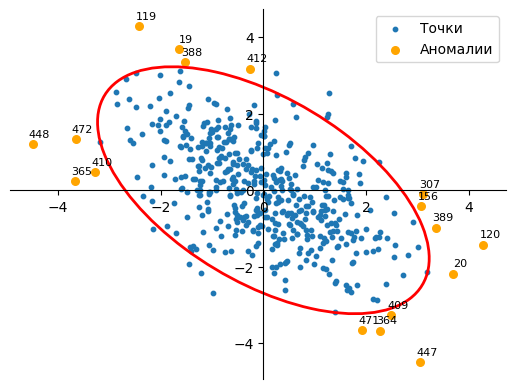

6 : 1.1419395327621031 -0.9917626337620207 4.715157560385922
7 : 5.857097093148026 4.715157560385922 -1.1628901904409776
72 : 5.326947931884705 0.46771726224131704 -4.170541881097353
73 : 1.156406050787352 -4.170541881097353 2.7744521878161317
111 : 0.9794099401538094 -0.11577107091942151 4.214213701244763
112 : 5.193623641398572 4.214213701244763 -2.716697680386575
182 : 1.6859203413244321 -0.6459196717764515 3.943132790051373
183 : 5.629053131375805 3.943132790051373 -4.566243342472744
184 : 1.0628097889030608 -4.566243342472744 1.3173483857297246
210 : 1.2720649086636378 -0.5687037972312272 5.0301935429939295
211 : 6.3022584516575675 5.0301935429939295 -4.272367660306356
212 : 2.029890791351211 -4.272367660306356 2.1125823020979686
239 : 1.7206497382724983 -0.43720460915414505 3.7941739940638675
240 : 5.514823732336366 3.7941739940638675 -4.436245425176146
290 : 1.431734414049584 -2.19725555092638 4.176002281634851
291 : 5.607736695684435 4.176002281634851 -3.623673040760597
338 : 5

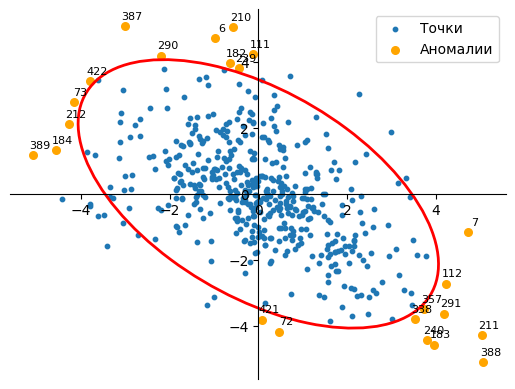

In [30]:
PARAM = 0.95

ellips(y1, PARAM)

ellips(y2, PARAM)

<h3>3) Исследование стационарности</h3>

In [31]:
def nums_max_series(X):
    series, max_series = 1, 0
    current_length = 1

    for i in range(1, len(X)):
        if X[i] == X[i-1]:
            current_length += 1
        else:
            max_series = max(max_series, current_length)
            series += 1
            current_length = 1
    return series, max(max_series, current_length)

In [34]:
def up_down_test(X, n):

    up_down = []

    for i in range(0, len(X)-1):
        if X[i+1] - X[i] > 0:
            up_down.append("+")
        elif X[i+1] - X[i] < 0:
            up_down.append("-")
        else:
            continue
    
    series, max_series = nums_max_series(up_down)
    
    nu = (2 * n) / 3 - 1.96 * np.sqrt((16*n - 29) / 90)
    tau = 6

    print(nu, series)
    print(tau, max_series)
    if series <= nu or max_series >= tau:
        return False    #Тренд есть
    else:
        return True     #Тренда нет

def median_test(X, n):
    median = np.median(X)
    
    test = []
    for i in range(len(X)):
        if X[i] > median:
            test.append("+")
        elif X[i] < median:
            test.append("-")
        else:
            continue
    
    series, max_series = nums_max_series(test)

    nu = 0.5 * (n + 2 - 1.96 * np.sqrt(n - 1))
    tau = 1.43 * np.log(n + 1)

    if series <= nu or max_series >= tau:
        return False    #Тренд есть
    else:
        return True     #Тренда нет


def series_analys(X, n):
    result_1 = []
    result_2 = []
    for i in range(0, len(X), n):
        segment = X[i:i+50]
        result_1.append(up_down_test(segment, n))
        result_2.append(median_test(segment, n))
    return result_1, result_2

In [35]:
n = 50
udt, mt = series_analys(y1, n)
print(udt)
print(mt)

27.596635095961368 37
6 3
27.596635095961368 36
6 3
27.596635095961368 38
6 3
27.596635095961368 35
6 4
27.596635095961368 36
6 5
27.596635095961368 33
6 3
27.596635095961368 32
6 4
27.596635095961368 31
6 3
27.596635095961368 35
6 3
27.596635095961368 31
6 5
[True, True, True, True, True, True, True, True, True, True]
[False, False, True, False, True, False, True, True, False, True]
